**Домашнее задание**

В данном задании вам предстоит помочь [The Nature Conservancy](https://www.nature.org/en-us/about-us/where-we-work/united-states/california/) в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. За основу решения предлагается взять модель [детектора](https://github.com/a4tunado/lectures/blob/master/007/007-detection.ipynb). Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на [Leaderboard](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/leaderboard).

# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.4.1


# Загружаем разметку

Задание выполнено в Google Colab.

Подключим Google Диск к Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
from glob import glob


def load_annotations(st_path):  ## st_path - путь, относительно которого
    boxes = dict()              ## происходит загрузка
    for path in glob(st_path + '/boxes/*.json'): ##
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                if label == "nof":                                                                     ##
                    annotation['filename'] = os.path.join(st_path + "/train", 'NoF', basename)         ## другое название папки
                else:
                    annotation['filename'] = os.path.join(st_path + "/train", label.upper(), basename) ##
                annotation['cl'] = label ## дописываем метку класса, она понадобится в генераторе
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y) # разметку отрисовывае одним цветом
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))                 # предсказание - другим

    return img

### Визуализируем разметку

Разметка для данной задачи была найдена на просторах [Интернета](https://github.com/Aminoid/The-Nature-Conservancy-Fisheries-Monitoring/tree/master/BBFish/annos). Предварительно еще исправил в ней ошибки и дополнил.

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/002'

boxes = load_annotations(base_dir + "/fish-real")  ## загружаем разметку детекций

In [ ]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()], columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,other,299
5,shark,176
6,yft,734
7,nof,465


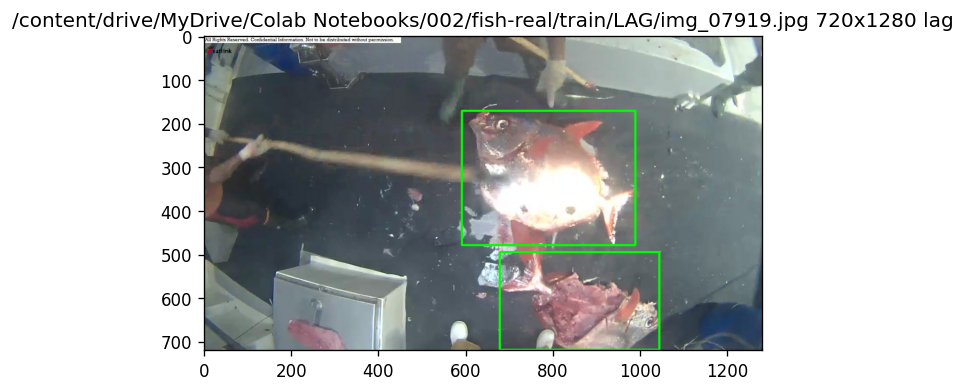

In [ ]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{} {}'.format(annotation['filename'], img.shape[0], img.shape[1], annotation['cl']));  ## добавим еще и вывод класса

### Распределение размеров разметки

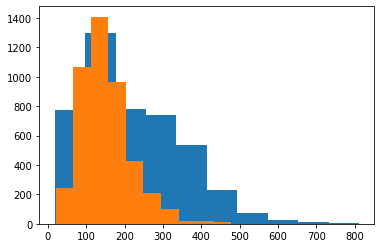

In [ ]:
annotations = sum([box['annotations'] for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [ ]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

На выходе VGG16 изображение размером 23x37. Под каждый пиксель этого изображения создаем сетку из якорей на исходном изображении.

In [ ]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

ANCHOR_CENTERS.shape, IMG_HEIGHT, FEATURE_SHAPE

((2, 23, 37), 750, (23, 37))

Определяемся с признаками и котовим функции OneHot-энкодинга для классов.

In [ ]:
CLASSES = list(boxes.keys())                ## все возможные классы
CLASS_FEATURES = len(CLASSES)               ## кол-во классов
FRAME_FEATURES = 5                          ## кол-во признаков рамки
TOTAL_FEATURES = FRAME_FEATURES + CLASS_FEATURES  ## общее кол-во признаков

def ohe_encode(label):             ## энкодер
  res = [0. for _ in range(len(CLASSES))]
  res[CLASSES.index(label)] = 1.
  return res

def ohe_decode_proba(lst):         ## декодер
  return CLASSES[lst.index(max(lst))]

In [ ]:
# метрика близости рамок
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

# упаковка: формирование тензора признаков
def encode_anchors(annotation, img_shape, class_features, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0], FEATURE_SHAPE[1], TOTAL_FEATURES), dtype=np.float32) # создаем пустой тензор признаков 23x37xTOTAL_FEATURES
    x_scale = 1. * IMG_WIDTH / img_shape[1]     # рассчитываем массштабирование по отношению к исходной картинке,
    y_scale = 1. * IMG_HEIGHT / img_shape[0]    # т.к. якорная сетка рассчитана под размеры исходной картинки
    for rect in annotation['annotations']:      # идем по каждой размеченной рамке и рассчитываем
        scores = []                             # как близко она к каждой нашей якорной рамке
        for row in range(FEATURE_SHAPE[0]):     # 23 
            for col in range(FEATURE_SHAPE[1]): # 37
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)   # сортируем по убыванию соответствия (iou)
        if scores[0][0] < iou_thr:              # если лучшее значение хуже нашего критерия отбора iou_thr,
            scores = [scores[0]]                # то ничего не остается, как выбрать его
        else:                                   # но если такое значение есть или их даже несколько - берем их
            scores = [e for e in scores if e[0] > iou_thr]

        # для каждого из отобранных значений считаем поправки (производные) по параметрам
        # и заносим их в тензор признаков
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh] + class_features  ## добавляем фичи классов
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):                   # делаем обход тензора признаков
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col][:FRAME_FEATURES]  ## получаем значения признаков рамок
            cl = prediction[row, col][FRAME_FEATURES:]    ## получаем значения признаков классификации
            conf = _sigmoid(logit)                        
            if conf > conf_thr:                           # если значение сигмоиды больше порога
                anchor_x = ANCHOR_CENTERS[1, row, col]    # получаем координаты якоря
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH, # восстанавливаем рамку
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'cl': cl.tolist(),     ## сохраняем значения признаков классификации
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],         # превращаем из x1,y1,w,h в x1,y1,x2,y2
              r['x'],         # перед применением встроенного non_max_suppression
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

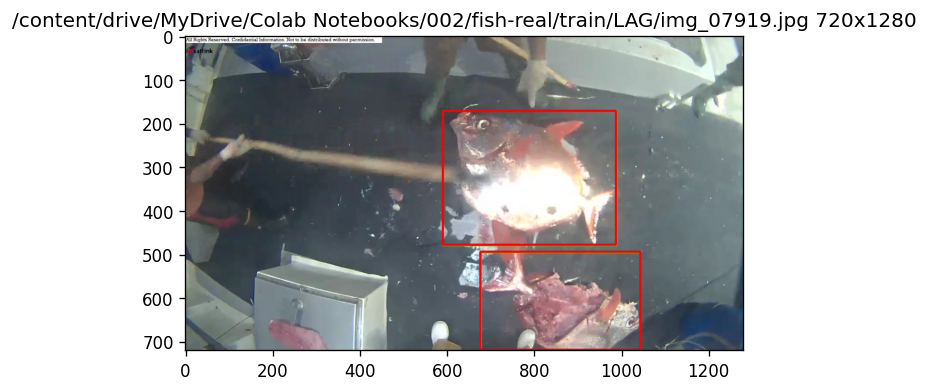

In [ ]:
annotation = boxes['lag'][0]
class_features = ohe_encode(annotation['cl'])  ## кодируем класс в OHE

encoded = encode_anchors(annotation, (IMG_HEIGHT, IMG_WIDTH), class_features, iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf']) # сортируем по убыванию conf

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

Для лучшего понимания выведем наши фичи.

In [ ]:
print("до обработки:")          ## выводим все фичи до и после обработки
for ann in annotation["annotations"]:
  if ann['class'] == "rect":
    print(f"x: {ann['x']}, \ty: {ann['y']}, \tw: {ann['width']}, \th: {ann['height']}, \tcs: {annotation['cl']}")
print("после:")
for da in decoded:
  print(f"x: {da['x']}, \ty: {da['y']}, \tw: {da['width']}, \th: {da['height']}, \tcs: {ohe_decode_proba(da['cl'])}, \tclass: {da['cl']}")

до обработки:
x: 790.0000000000019, 	y: 325.0000000000008, 	w: 398.0000000000009, 	h: 308.0000000000008, 	cs: lag
x: 861.000000000002, 	y: 607.0000000000015, 	w: 366.0000000000008, 	h: 224.0000000000005, 	cs: lag
после:
x: 790.000001723702, 	y: 324.9999985098839, 	w: 397.99999594688416, 	h: 307.99999237060547, 	cs: lag, 	class: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
x: 860.999999497388, 	y: 606.9999996410764, 	w: 366.00000858306885, 	h: 224.00000095367432, 	cs: lag, 	class: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


## Функция потерь

In [ ]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:FRAME_FEATURES] - y_pred[..., 1:FRAME_FEATURES])             ## выбираем нужные фичи
    square_loss = 0.5 * K.square(y_true[..., 1:FRAME_FEATURES] - y_pred[..., 1:FRAME_FEATURES]) ## выбираем нужные фичи
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_true, y_pred):  ## функция потерь классификации
    class_loss = K.categorical_crossentropy(y_true[..., FRAME_FEATURES:], 
                                      y_pred[..., FRAME_FEATURES:],
                                      from_logits=True)
    return class_loss

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, TOTAL_FEATURES))
    y_pred = K.reshape(y_pred, (batch_size, -1, TOTAL_FEATURES))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    ## class loss
    class_loss = classification_loss(y_true, y_pred) ##
    #print(class_loss.shape)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    pos_class_loss = K.sum(class_loss * y_true[..., 0], axis=-1) ## зануляем функцию, если детектор ничего не нашел
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    class_loss = pos_class_loss ##
    
    return total_conf_loss + 0.5 * loc_loss + class_loss ## включаем в общую сумму потерь

## Загрузка данных

In [ ]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                class_features = ohe_encode(boxes[j]['cl']) ## представляем класс в OHE
                y.append(encode_anchors(boxes[j], img_shape, class_features))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [ ]:
def layer_slice1(x):
    return x[..., :FRAME_FEATURES]
def layer_slice2(x):
    return x[..., FRAME_FEATURES:]

output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции

var = 1 ## тут несколько вариантов сборки модели, остановимся на варианте 1

if var == 0:
  output = tf.keras.layers.Conv2D(TOTAL_FEATURES,
                                  kernel_size=(1, 1), 
                                  activation='linear',
                                  kernel_regularizer='l2')(output)

if var == 1:
  o = tf.keras.layers.Conv2D(TOTAL_FEATURES,  ## выполняем 1x1 свертку и получаем TOTAL_FEATURES выходов
                                  kernel_size=(1, 1), 
                                  activation='linear',
                                  kernel_regularizer='l2')(output)
  o1 = tf.keras.layers.Lambda(layer_slice1)(o) ## разделяем признаки рамки
  o2 = tf.keras.layers.Lambda(layer_slice2)(o) ## и признаки классов
  o2 = tf.keras.layers.Dense(CLASS_FEATURES, activation='softmax')(o2) ## выполняем над признаками класса softmax
  output = tf.keras.layers.Concatenate()([o1, o2]) ## собираем признаки воедино
  #output = [o1, o2]

elif var == 2:
  o1 = tf.keras.layers.Conv2D(FRAME_FEATURES,
                                  kernel_size=(1, 1), 
                                  activation='linear',
                                  kernel_regularizer='l2')(output)
  o2 = tf.keras.layers.Dense(CLASS_FEATURES, activation='softmax')(output)
  output = tf.keras.layers.Concatenate()([o1, o2])

elif var == 3:
  o = tf.keras.layers.Conv2D(TOTAL_FEATURES,
                                  kernel_size=(1, 1), 
                                  activation='linear',
                                  kernel_regularizer='l2')(output)
  o1 = tf.keras.layers.Lambda(layer_slice1)(o)
  o2 = tf.keras.layers.Lambda(layer_slice2)(o)
  o2 = tf.keras.layers.Dense(CLASS_FEATURES, activation='softmax')(o2)
  output = [o1, o2]

elif var == 4:
  o1 = tf.keras.layers.Conv2D(FRAME_FEATURES,
                                  kernel_size=(1, 1), 
                                  activation='linear',
                                  kernel_regularizer='l2')(output)
  o2 = tf.keras.layers.Dense(CLASS_FEATURES, activation='softmax')(output)
  output = [o1, o2]


model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 750, 1200, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 750, 1200, 64 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 750, 1200, 64 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 375, 600, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Обучение

In [ ]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss, classification_loss]) ## добавим отображение classification_loss

In [ ]:
batch_size = 16 ##

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    base_dir + '/fishdetector.hdf5', ##
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=100) ##

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          callbacks=[checkpoint])

Epoch 1/25
100/236 [===========>..................] - ETA: 3:08 - loss: 6.7050 - confidence_loss: 0.7069 - classification_loss: 0.0052
Epoch 00001: loss improved from inf to 5.63012, saving model to /content/drive/MyDrive/Colab Notebooks/002/fishdetector.hdf5
200/236 [========================>.....] - ETA: 49s - loss: 6.0619 - confidence_loss: 0.6221 - classification_loss: 0.0051
Epoch 00001: loss improved from 5.63012 to 5.26392, saving model to /content/drive/MyDrive/Colab Notebooks/002/fishdetector.hdf5
236/236 [==============================] - 331s 1s/step - loss: 5.9297 - confidence_loss: 0.5988 - classification_loss: 0.0050
Epoch 2/25
 63/236 [=======>......................] - ETA: 3:58 - loss: 4.5915 - confidence_loss: 0.2894 - classification_loss: 0.0045
Epoch 00002: loss improved from 5.26392 to 4.56753, saving model to /content/drive/MyDrive/Colab Notebooks/002/fishdetector.hdf5
163/236 [===================>..........] - ETA: 1:41 - loss: 4.5789 - confidence_loss: 0.2758 - c

Как видим, модель в целом обучается, хотя ошибка классификации почти не меняется. Возможно, неверные настройки, либо imagenet хорошо помогает. На результате всё увидим.

In [ ]:
model_weights = base_dir + "/fishdetector_full.hdf5" ## определяем место для весов
model.save(model_weights)          ## сохраняем веса

## Результат работы детектора

In [ ]:
## тут можно загружать как конечные веса, так и веса на стадии чекпоинтов (там они даже лучше могут быть)
# model.load_weights(model_weights)

x: 752.1338102382583, 	y: 350.12787016837495, 	w: 372.33917713165283, 	h: 345.31949758529663, 	cs: lag, 	class: [3.1456413580599474e-06, 1.6462319507581924e-08, 4.602835304012842e-07, 0.9999865293502808, 6.48452896712115e-07, 8.569164492655545e-06, 4.496740402260002e-08, 7.592549309265451e-07]
x: 806.0060214351964, 	y: 633.1056169517663, 	w: 367.88633465766907, 	h: 247.22852110862732, 	cs: lag, 	class: [2.025349203904625e-06, 3.457877895129968e-08, 1.4211634606908774e-06, 0.9999879598617554, 6.716988423249859e-07, 6.491322892543394e-06, 2.211650382832886e-07, 1.2280157761779265e-06]


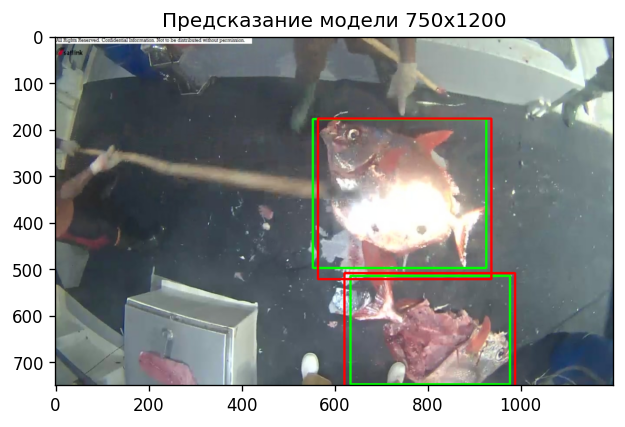

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));
for da in decoded: ## выводим предсказанные фичи
  print(f"x: {da['x']}, \ty: {da['y']}, \tw: {da['width']}, \th: {da['height']}, \tcs: {ohe_decode_proba(da['cl'])}, \tclass: {da['cl']}")

## Визуализируем предсказание на тесте

In [ ]:
def out_result(decoded, filename, prefix=''):       ## функция селекции результата и вывода строки ответа
    labels = ["alb", "bet", "dol", "lag", "nof", "other", "shark", "yft"]
    line = [prefix + os.path.basename(filename)]
    if len(decoded) == 0:
        line += ["0", "0", "0", "0", "1", "0", "0", "0"]
    else:
        dc = decoded[0]
        for label in labels:
            line.append(f"{dc['cl'][CLASSES.index(label)]:.6f}")
    return ",".join(line)

image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
img_00007.jpg,0.528795,0.045894,0.000997,0.003486,0.003371,0.003416,0.005085,0.408955
img_00551.jpg,0.999995,0.000002,0.000000,0.000001,0.000000,0.000001,0.000000,0.000001
img_00196.jpg,0,0,0,0,1,0,0,0
img_00575.jpg,0.259288,0.024381,0.004337,0.008964,0.006220,0.002499,0.010475,0.683837
img_00493.jpg,0,0,0,0,1,0,0,0


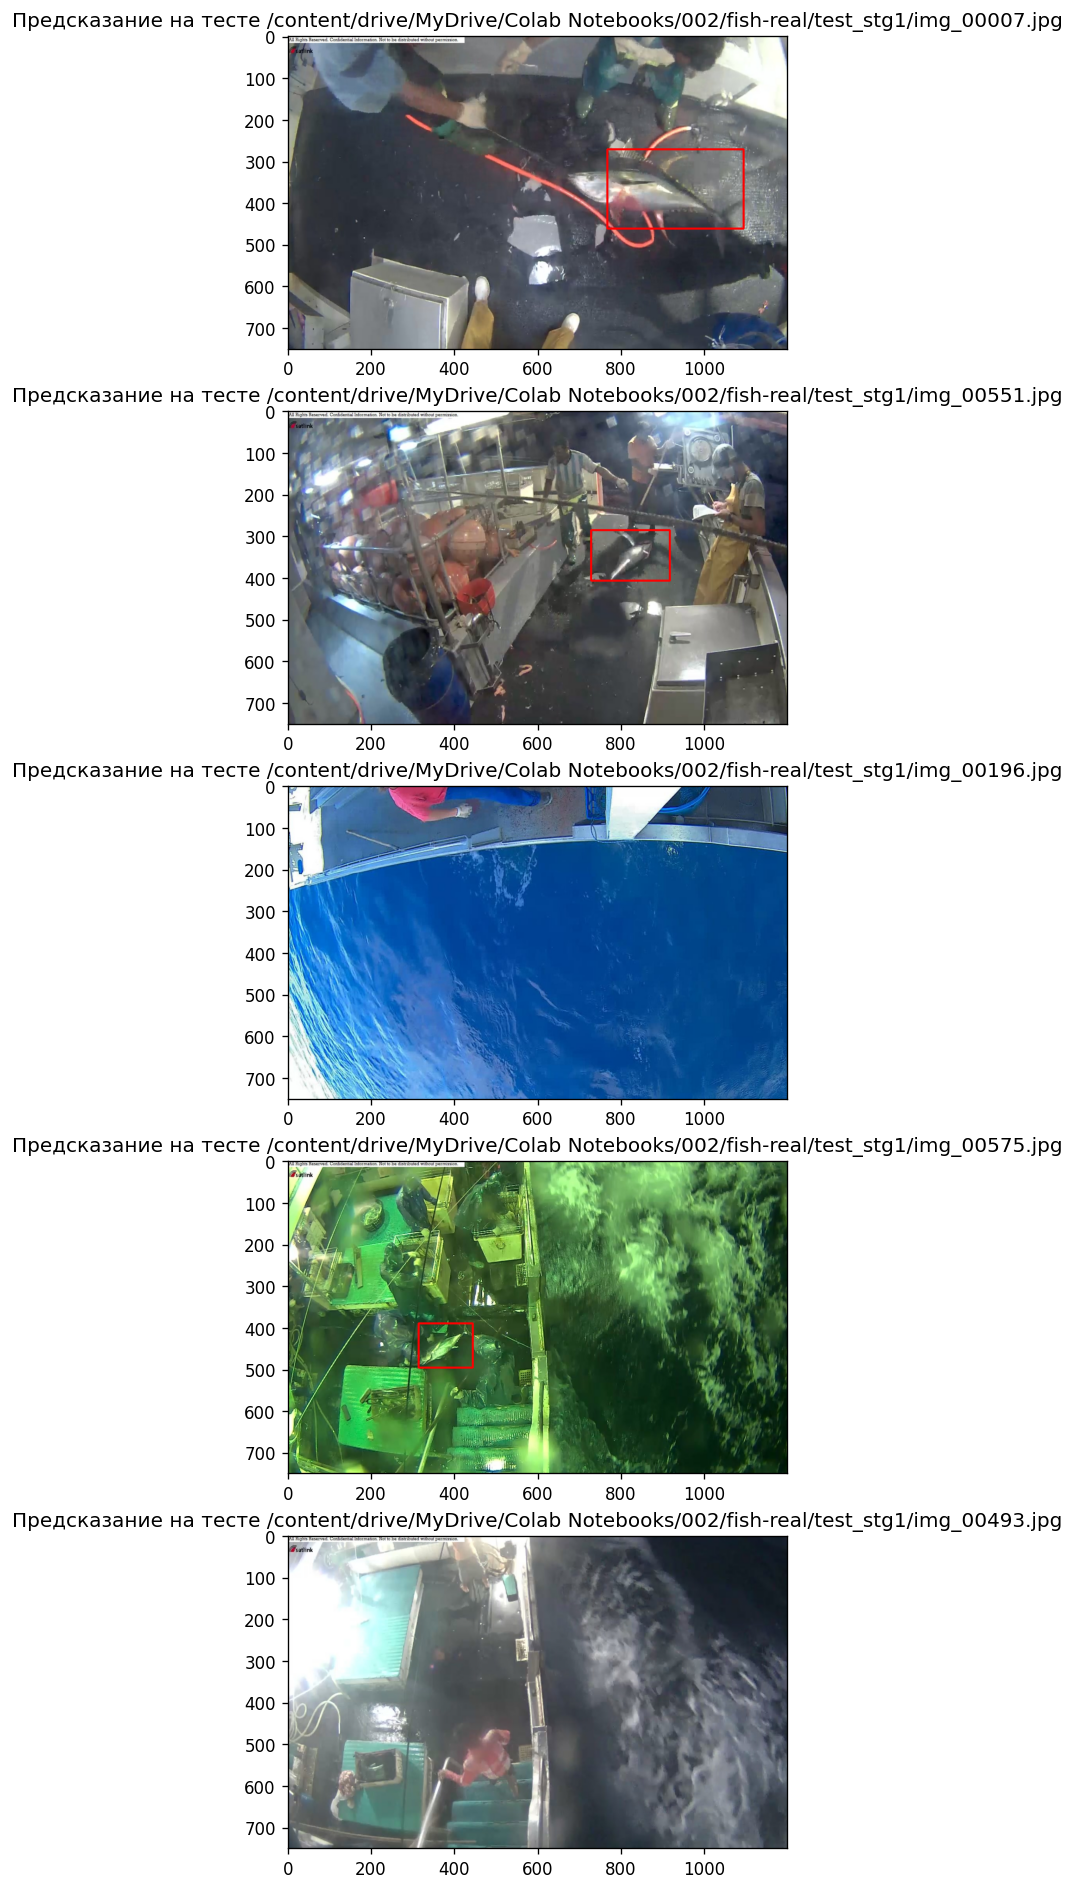

In [ ]:
test_images = glob(base_dir + '/fish-real/test_stg1/*.jpg')[:5]

plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

print("image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT")
for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded_full = decode_prediction(pred[0], conf_thr=0.1) #0.6
    decoded = non_max_suppression(decoded_full,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

    print(out_result(decoded, filename)) ## выведем еще и числовое представление

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

def gen_and_save(files, result_file, append=False, prefix=''):
    if append:
        mode = "a"
    else:
        mode = "w"
    with open(result_file, mode) as f:
        if not append:
            f.write("image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n")
        test_images = sorted(glob(files))

        for i, filename in enumerate(test_images):
            _, sample_img = load_img(filename)
            pred = model.predict(np.array([sample_img,]))

            decoded_full = decode_prediction(pred[0], conf_thr=0.1) #0.6
            decoded = non_max_suppression(decoded_full,
                                        max_output_size=2,
                                        iou_threshold=0.1)
            
            f.write(f"{out_result(decoded, filename, prefix)}\n")


result_file = base_dir + '/submission.csv'
gen_and_save(base_dir + '/fish-real/test_stg1/*.jpg', result_file, False)
gen_and_save(base_dir + '/fish-real/test_stg2/*.jpg', result_file, True, "test_stg2/")

## Результат оценки работы модели на test-выборке на Kaggle.

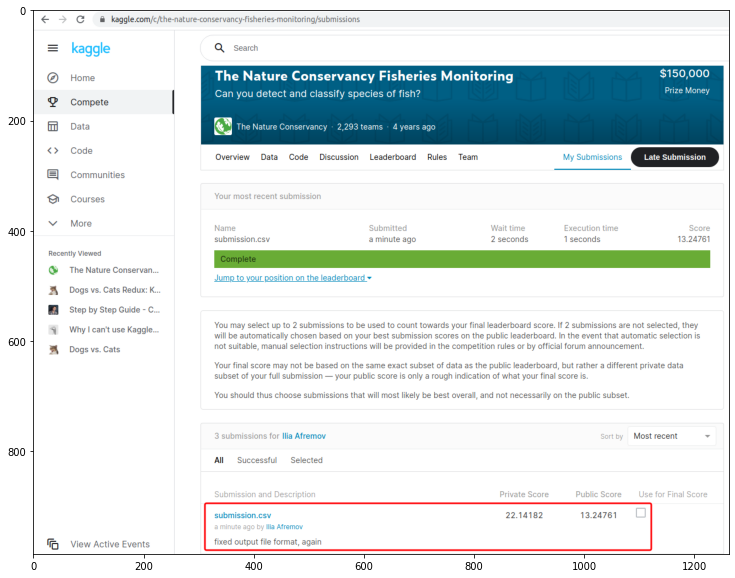

In [ ]:
img_cv = cv2.imread(base_dir + "/kaggle-score.png")
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 10))
plt.imshow(img_rgb)
plt.show()

Результат работы модели получился далеко не лучший. Однако, при достаточном времени на выполнение дз тут есть что еще доработать: разобраться с функцией loss, покрутить параметры порогов, доработать функцию селекции результатов. Также можно выделить отдельно модель классификатора и обучить ее не на полном изображении, а на разметке и скомбинировать с текущей моделью.